# KDD Cup 1999 - Keşifsel Veri Analizi (EDA)

Bu notebook, KDD Cup 1999 veri setinin keşifsel veri analizini içerir.

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data import load_kdd, KDD_COLS, ATTACK_FAMILY
from src.preprocess import add_targets, split_features
from src.viz import boxplots, plot_attack_distribution, plot_service_attack_ratio, plot_correlation_heatmap

# Görselleştirme ayarları
plt.style.use('default')
sns.set_palette('husl')
%matplotlib inline

## 1. Veri Yükleme

**Not:** Veri dosyalarını `data/` klasörüne yerleştirdiğinizden emin olun.

In [2]:
# Veri yükleme (dosya yollarını kendi sisteminize göre ayarlayın)
try:
    train_raw = load_kdd('../data/kddcup.data_10_percent.gz')
    test_raw = load_kdd('../data/corrected.gz')
    print(f"Train veri boyutu: {train_raw.shape}")
    print(f"Test veri boyutu: {test_raw.shape}")
except FileNotFoundError:
    print("Veri dosyaları bulunamadı. Lütfen data/ klasörüne KDD Cup 1999 dosyalarını yerleştirin.")

Train veri boyutu: (494021, 42)
Test veri boyutu: (311029, 42)


## 2. Temel Veri İncelemesi

In [3]:
# Temel bilgiler
print("Kolon isimleri:")
print(train_raw.columns.tolist())
print(f"\nToplam kolon sayısı: {len(train_raw.columns)}")

# İlk birkaç satır
print("\nİlk 5 satır:")
train_raw.head()

Kolon isimleri:
['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label']

Toplam kolon sayısı: 42

İlk 5 satır:


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [4]:
# Veri tipleri ve eksik değerler
print("Veri tipleri:")
print(train_raw.dtypes)

print("\nEksik değer sayıları:")
print(train_raw.isnull().sum().sum())

print("\nTemel istatistikler:")
train_raw.describe()

Veri tipleri:
duration                         int64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,494021.000000,4.940210e+05,4.940210e+05,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,...,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000,494021.000000
mean,47.979302,3.025610e+03,8.685324e+02,0.000045,0.006433,0.000014,0.034519,0.000152,0.148247,0.010212,...,232.470778,188.665670,0.753780,0.030906,0.601935,0.006684,0.176754,0.176443,0.058118,0.057412
std,707.746472,9.882181e+05,3.304000e+04,0.006673,0.134805,0.005510,0.782103,0.015520,0.355345,1.798326,...,64.745380,106.040437,0.410781,0.109259,0.481309,0.042133,0.380593,0.380919,0.230590,0.230140
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4.500000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,46.000000,0.410000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,5.200000e+02,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.032000e+03,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,255.000000,255.000000,1.000000,0.040000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,58329.000000,6.933756e+08,5.155468e+06,1.000000,3.000000,3.000000,30.000000,5.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 3. Hedef Değişken Analizi

In [5]:
# Hedef değişkenleri ekle
train = add_targets(train_raw)
test = add_targets(test_raw)

# Label dağılımı
print("Train set - Label dağılımı:")
print(train['label'].value_counts())

print("\nTrain set - Binary dağılım:")
print(train['y_binary'].value_counts())

print("\nTrain set - Attack family dağılımı:")
print(train['y_family'].value_counts())

Train set - Label dağılımı:
label
smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: count, dtype: int64

Train set - Binary dağılım:
y_binary
1    494021
Name: count, dtype: int64

Train set - Attack family dağılımı:
Series([], Name: count, dtype: int64)


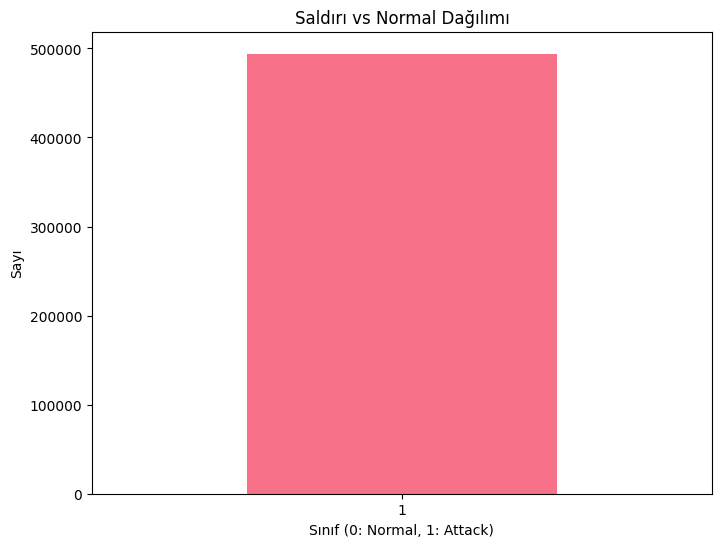

In [6]:
# Saldırı dağılımını görselleştir
plot_attack_distribution(train)

## 4. Kategorik Değişken Analizi

In [7]:
# Kategorik değişkenlerin benzersiz değer sayıları
categorical_cols = ['protocol_type', 'service', 'flag']

for col in categorical_cols:
    print(f"{col}: {train[col].nunique()} benzersiz değer")
    print(train[col].value_counts().head(10))
    print("" + "-"*50)

protocol_type: 3 benzersiz değer
protocol_type
icmp    283602
tcp     190065
udp      20354
Name: count, dtype: int64
--------------------------------------------------
service: 66 benzersiz değer


service
ecr_i       281400
private     110893
http         64293
smtp          9723
other         7237
domain_u      5863
ftp_data      4721
eco_i         1642
ftp            798
finger         670
Name: count, dtype: int64
--------------------------------------------------
flag: 11 benzersiz değer
flag
SF        378440
S0         87007
REJ        26875
RSTR         903
RSTO         579
SH           107
S1            57
S2            24
RSTOS0        11
S3            10
Name: count, dtype: int64
--------------------------------------------------


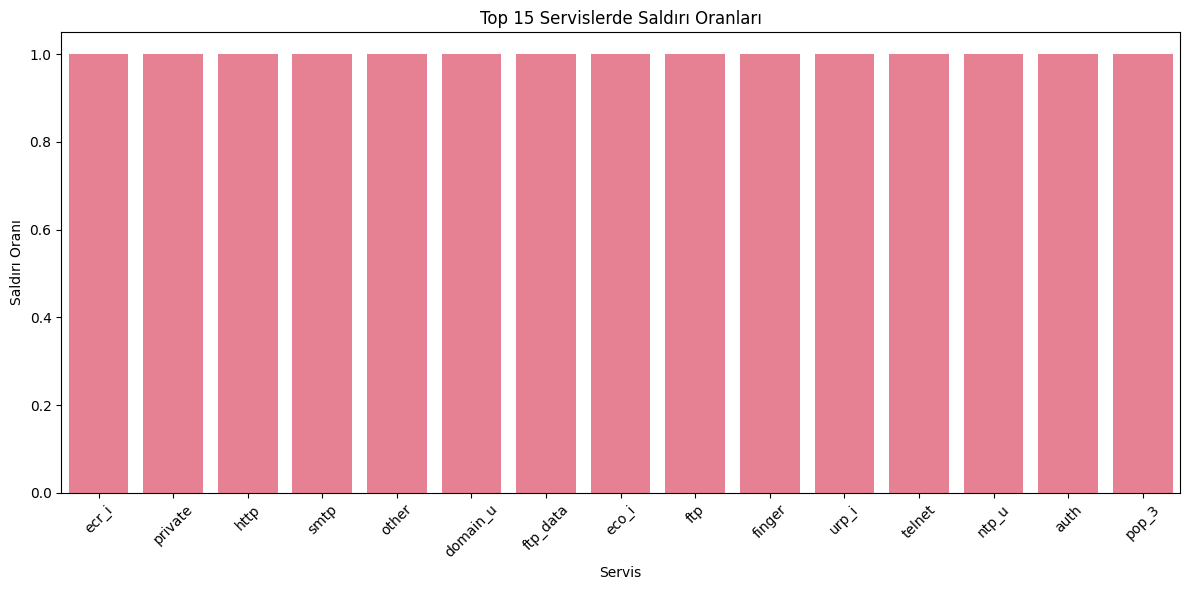

In [8]:
# Servis bazında saldırı oranları
plot_service_attack_ratio(train, top_n=15)

## 5. Sayısal Değişken Analizi

In [9]:
# Sıfır varyanslı kolonları tespit et
numeric_cols = train.select_dtypes(include=[np.number]).columns
zero_variance_cols = []

for col in numeric_cols:
    if train[col].nunique() <= 1:
        zero_variance_cols.append(col)

print(f"Sıfır varyanslı kolonlar: {zero_variance_cols}")

Sıfır varyanslı kolonlar: ['num_outbound_cmds', 'is_host_login', 'y_binary']


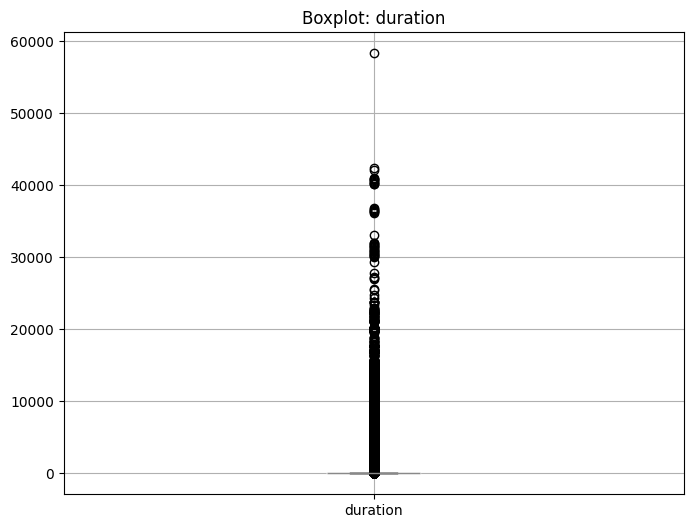

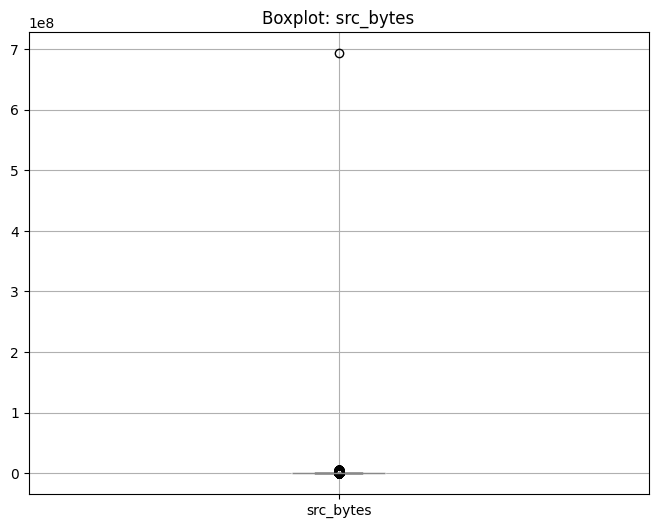

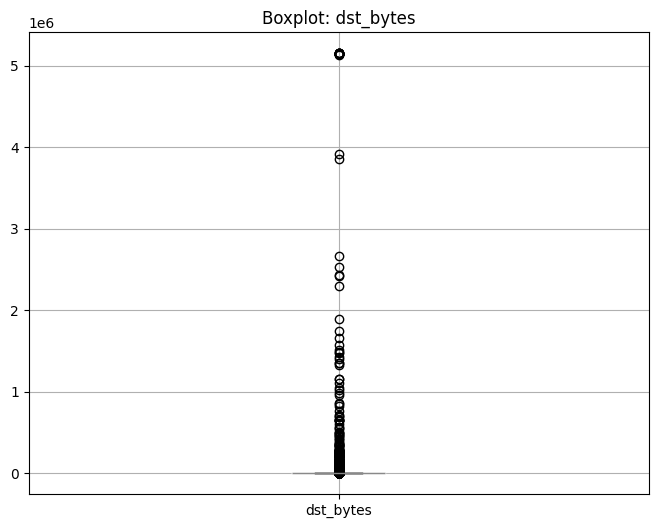

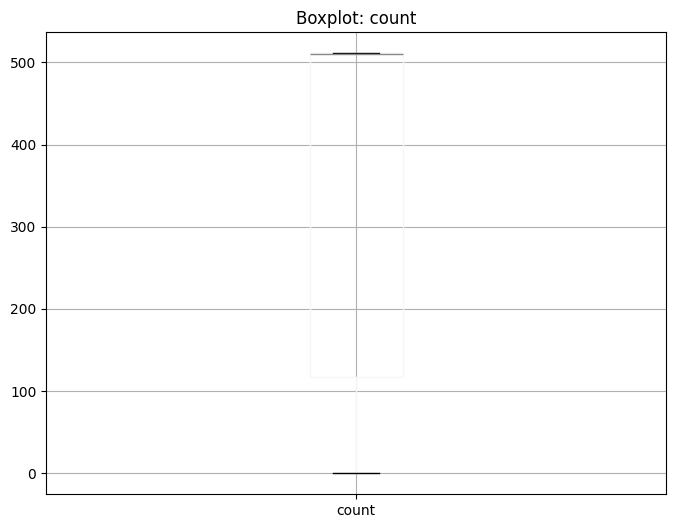

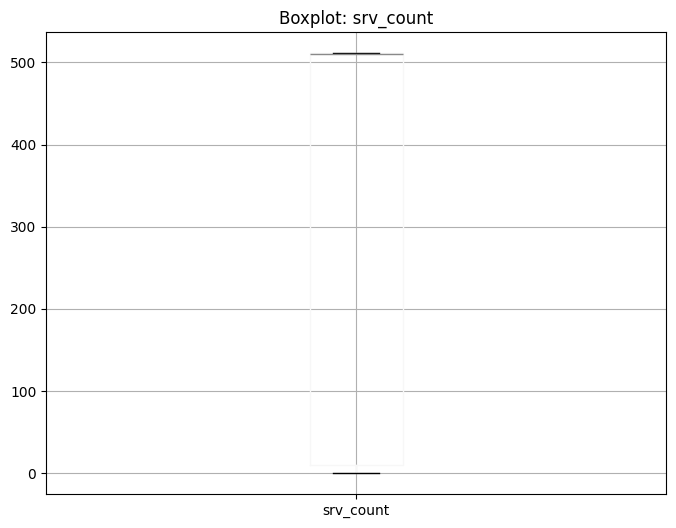

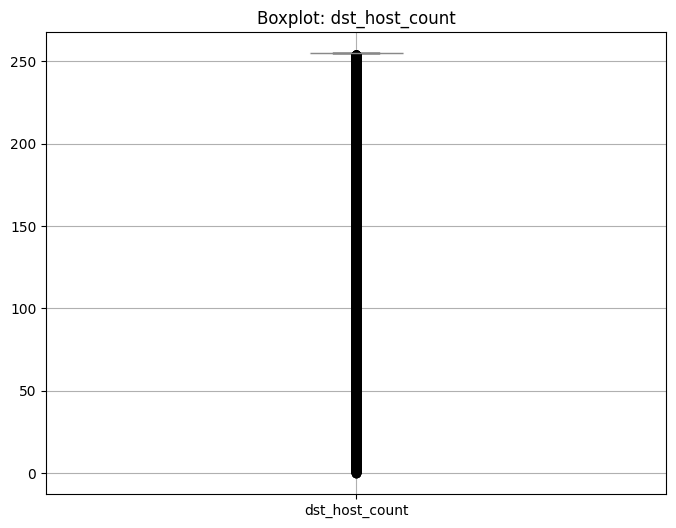

In [10]:
# Önemli sayısal değişkenler için boxplot
important_cols = ['duration', 'src_bytes', 'dst_bytes', 'count', 'srv_count', 'dst_host_count']
boxplots(train, important_cols)

## 6. Korelasyon Analizi

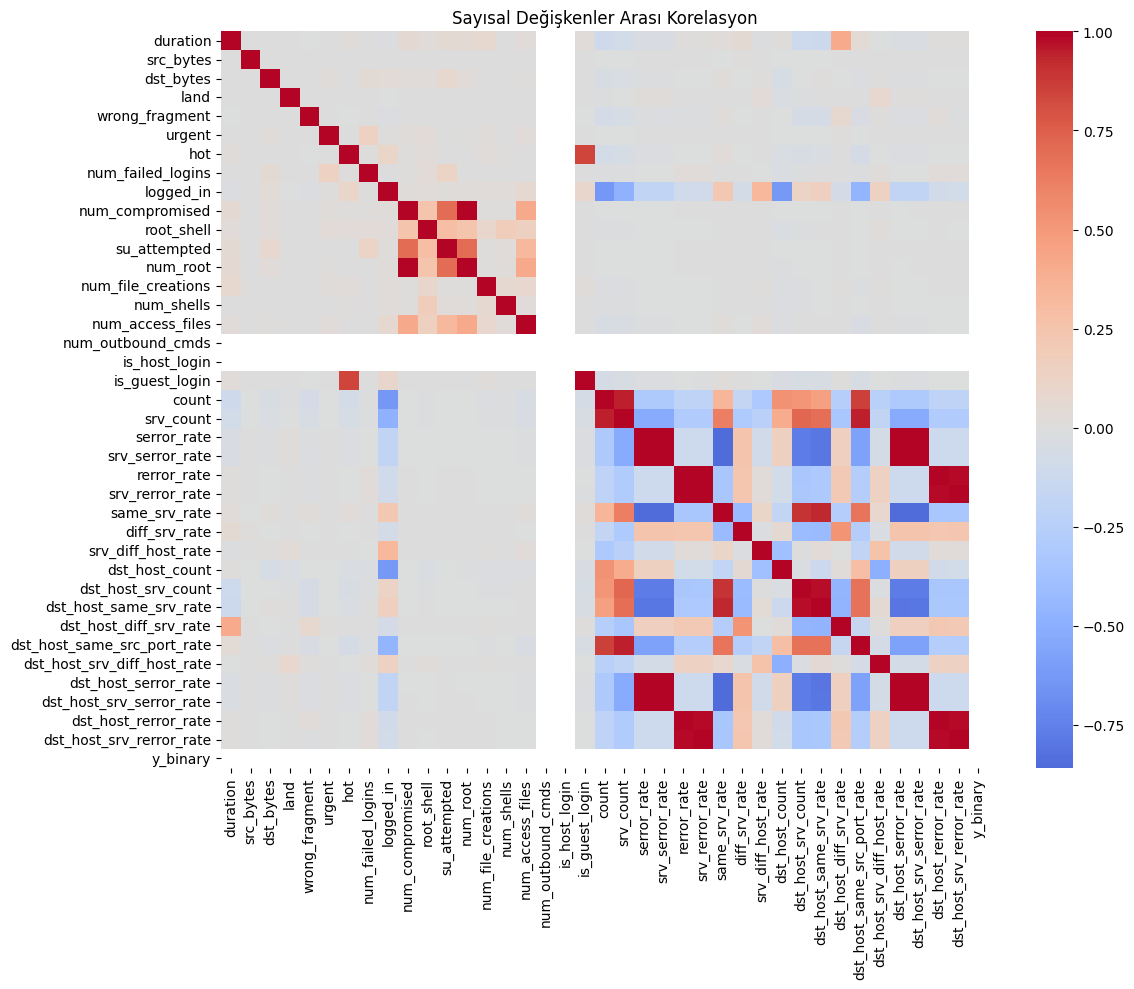

In [11]:
# Korelasyon ısı haritası
plot_correlation_heatmap(train)

## 7. Aykırı Değer Analizi

In [12]:
from src.viz import zscore_outliers

# Z-score ile aykırı değerleri tespit et
outlier_cols = ['src_bytes', 'dst_bytes', 'count', 'srv_count']
outliers, z_scores = zscore_outliers(train, outlier_cols, threshold=3.0)

print(f"Toplam aykırı değer sayısı: {len(outliers)}")
print(f"Toplam veri sayısına oranı: {len(outliers)/len(train)*100:.2f}%")

Toplam aykırı değer sayısı: 238
Toplam veri sayısına oranı: 0.05%


## 8. Tekrar Eden Kayıtlar

In [13]:
# Tekrar eden kayıtları kontrol et
duplicates = train.duplicated().sum()
print(f"Tekrar eden kayıt sayısı: {duplicates}")
print(f"Toplam veriye oranı: {duplicates/len(train)*100:.2f}%")

Tekrar eden kayıt sayısı: 348435
Toplam veriye oranı: 70.53%


## 9. Özet ve Sonuçlar

Bu EDA sonucunda elde edilen temel bulgular:

1. **Veri Boyutu**: Train ve test setlerinin boyutları
2. **Sınıf Dengesizliği**: Normal vs saldırı oranları
3. **Kategorik Değişkenler**: Protocol, service, flag değişkenlerinin dağılımları
4. **Sayısal Değişkenler**: Aykırı değerler ve dağılımlar
5. **Veri Kalitesi**: Eksik değerler, tekrar eden kayıtlar, sıfır varyanslı kolonlar

**Sonraki Adımlar:**
- Binary sınıflandırma modeli geliştirme
- Multi-class sınıflandırma modeli geliştirme
- Model performanslarının karşılaştırılması